In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
import os
import numpy as np
import re
import time
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Tc = 2.269

# 01. Prepare the dataset
class IsingDataset(Dataset):
    def __init__(self, temp, L = 30):
        self.L = L
        BASE_DIR = "Data_configurations"
        
        # Prepare the data list
        data_list = []
        
        # Read the data
        
        file = os.path.join(BASE_DIR, f"{L}", f"L{L}_T{temp:.4f}.npy")
            
        # Load file
        data_np = np.load(file)
        
        for ele in data_np[:100]:
            ele_flatten = ele.flatten()
            data_list.append(ele_flatten)
        
        # Prepare the data and label tensor
        data_list = np.array(data_list)
        self.data = torch.tensor(data_list, dtype=torch.float32)
        if temp < Tc:
            self.label = torch.zeros(len(data_list), dtype=torch.long)
        else:
            self.label = torch.ones(len(data_list), dtype=torch.long)
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
    def __getall__(self):
        return self.data, self.label
    
# 02. Define the model
class FNN(nn.Module):
    def __init__(self, L = 30, hidden_dim = 100, output_dim=2):
        input_dim = L * L
        super(FNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim = 1)
        )
        
    def forward(self, x):
        return self.fc(x)

In [2]:
# Load the model
L = 30
model_path = f"model_regression_demo/model_{L}.pth"
model = FNN(L).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

FNN(
  (fc): Sequential(
    (0): Linear(in_features=900, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=2, bias=True)
    (3): Softmax(dim=1)
  )
)

In [3]:
# Prepare the data
T_list = np.linspace(1.0, 3.5, 1000)
T_list = T_list[::50]
prob_list = []
std_list = []

total = 0
correct = 0

for T in tqdm(T_list):
    dataset_T = IsingDataset(round(T,4), L)
    data, label = dataset_T.__getall__()
    data = data.to(device)
    label = label.to(device)
    
    # Predict the data
    with torch.no_grad():
        output = model(data)
        softmax_prob = output[:, 1].cpu().numpy()
        
        
        _, predicted = torch.max(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        
        softmax_mean = np.mean(softmax_prob)
        softmax_std = np.std(softmax_prob)
        prob_list.append(softmax_mean)
        std_list.append(softmax_std)
        
print("Accuracy:", correct / total)
        

100%|██████████| 20/20 [00:00<00:00, 227.73it/s]

Accuracy: 0.9775


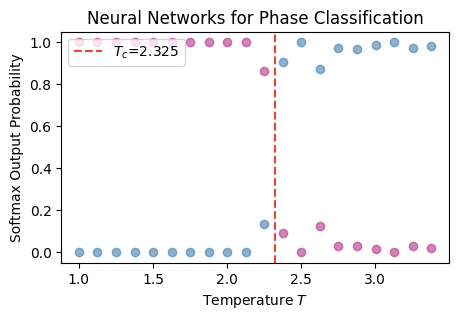

Fitted Tc: 2.325


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import pandas as pd
import matplotlib.pyplot as plt

# 定义阶跃函数
def step_function(T, Tc):
    return np.where(T >= Tc, 1, 0)

# 定义误差函数
def loss(Tc, T, y):
    y_pred = step_function(T, Tc)
    return np.sum((y - y_pred) ** 2)

# 初始猜测的 Tc
Tc_initial = 3

# 使用最小化函数拟合 Tc
result = minimize(loss, Tc_initial, args=(T_list, prob_list), method='Nelder-Mead')
Tc_fitted = result.x[0]

# 可视化结果
plt.figure(figsize=(5, 3))
plt.scatter(T_list, prob_list, color='#3f7fb1', alpha=0.6)
plt.scatter(T_list, [1 - x for x in prob_list], color='#b53289', alpha=0.6)
# plt.plot(T_list, step_function(T_list, Tc_fitted), label=f'Fitted Line (Tc={Tc_fitted:.3f})', color='red')
plt.axvline(Tc_fitted, color='#e64532', linestyle='--', label=f'$T_c$={Tc_fitted:.3f}')
# Define the location of the legend
plt.legend(loc='upper left')
plt.xlabel(r'Temperature $T$')
plt.ylabel('Softmax Output Probability')
plt.title('Neural Networks for Phase Classification')
plt.savefig(f"fig_demo/classification_{L}.png", dpi=600, bbox_inches='tight')
plt.show()

# 输出拟合结果
print(f"Fitted Tc: {Tc_fitted:.3f}")